In [1]:
print('hellow world')

hellow world


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import openai
import pandas as pd
import os
import json
import matplotlib.pyplot as plt  


In [4]:
# 필드 추출 함수 정의
def extract_fields(description):
    prompt = f"""
    우리는 여러 플랫폼에서 크롤링한 데이터를 통해 호텔과 숙박에 관한 노쇼 상품들을 판매할거야. 
    기본 필드에서 가져올 수 있는 정보들을 제외하고 우리가 필요한 필드가 8개가 있어. 
    이 8개의 필드는 
    1. 노쇼 상품의 사용 날짜 및 기한을 나타내는 expiration_date
    이때 날짜가 범위로 표현되어 있다면 범위를 나타내줘.
    2. 배송비인 shipping_fee 
    3. 직거래인지 택배거래인지 알 수 있는 거래 유형인 transaction_method
    4. 원래 노쇼 상품의 가격인 시중 가격인 market_price 
    5. 조식 여부나 사우나 여부, 수영장 여부 등의 호텔에서 사용할 수 있는 서비스 이용 여부를 알 수 있는 옵션인 options
    6. 주차 여부를 나타내는 parking
    7. 호텔 체크인/체크 아웃 시간을 나타내는 check_in_out_time
    8. 나머지 상세 정보들을 기입하는 detail
    그래서 상세 설명을 주면 거기서 8개의 필드에 해당하는 정보를 json형태로 추출해줘:

    설명: {description}
    
    필드:
    - expiration_date:
    - shipping_fee:
    - transaction_method:
    - market_price:
    - options:
    - parking:
    - check_in_out_time:
    - detail:
    """
    
    # OpenAI API 호출
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200
    )
    
    # 결과 추출
    result = response['choices'][0]['message']['content'].strip()

    # JSON 형식인지 확인하고 변환
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        # JSON 디코딩에 실패한 경우 원본 텍스트 반환
        result_json = {"error": "Invalid JSON format", "content": result}
    
    return result_json

# 예시 데이터프레임 생성
data = {
    '상세설명': [
        "9/28 오늘 대전 베스트인시티 디럭스트윈 숙박 양도 주차가능\n추가금시 4인까지 숙박 가능한 룸입니다\n원가 16만원 11만에 올립니다.\n주차포함입니다",
        "10/3 예약 양도합니다.(정상가 130만)\n사우나, 실내수영장, 피트니스, 라운드풀 2인 이용 가능합니다.\n호텔에서 직거래로 양도하겠습니다.\n4인 기준 객실 6인까지 이용 가능합니다.\n가장 큰 객실입니다.\n날짜 변경 가능하시니 문의 주세요.",
        "이번 주말인 9월 28일~29일 제주 시티 라마다 호텔 예약 양도합니다. 환불 불가 취소라 아까워서 양도합니다.\n식사 불포함, 스탠다드 트윈 룸입니다. 체크인 14시부터 체크아웃 11시입니다. 1박 50000원에 양도합니다~!"
    ]
}

df = pd.DataFrame(data)

# 데이터 프레임의 각 행에 대해 필드 추출 적용
df['추출된 필드'] = df['상세설명'].apply(extract_fields)

# 결과 확인
print(df[['상세설명', '추출된 필드']])

                                                상세설명  \
0  9/28 오늘 대전 베스트인시티 디럭스트윈 숙박 양도 주차가능\n추가금시 4인까지 ...   
1  10/3 예약 양도합니다.(정상가 130만)\n사우나, 실내수영장, 피트니스, 라운...   
2  이번 주말인 9월 28일~29일 제주 시티 라마다 호텔 예약 양도합니다. 환불 불가...   

                                              추출된 필드  
0  {'expiration_date': '9/28', 'shipping_fee': No...  
1  {'error': 'Invalid JSON format', 'content': '`...  
2  {'expiration_date': '9월 28일 ~ 9월 29일', 'shippi...  


In [5]:
def extract_fields(description):
    prompt = f"""
    우리는 여러 플랫폼에서 크롤링한 데이터를 통해 호텔과 숙박에 관한 노쇼 상품들을 판매할 거야. 
    8개의 필드를 추출해줘: 
    1. 노쇼 상품의 사용 날짜 및 기한을 나타내는 expiration_date
    이때 날짜가 범위로 표현되어 있다면 범위를 나타내줘.
    2. 배송비인 shipping_fee 
    3. 거래 유형인 transaction_method (직거래 또는 택배거래) 
    4. 시중 가격인 market_price 
    5. 호텔에서 사용할 수 있는 서비스 옵션인 options (사우나, 조식 등) 
    6. 주차 여부를 나타내는 parking 
    7. 체크인/체크아웃 시간을 나타내는 check_in_out_time 
    8. 기타 상세 정보를 나타내는 detail
    
    설명: {description}
    
    가능한 한 JSON 형식으로 반환해줘. 각 필드에 값을 할당할 수 없는 경우 "null"로 입력해줘.
    """
    
    # OpenAI API 호출
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=300
    )
    
    result = response['choices'][0]['message']['content'].strip()

    # 응답 내용을 확인 (디버깅)
    print("응답 확인: ", result)

    # JSON 형식 변환 시도
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        # JSON 형식이 아니면 원본 텍스트 반환
        result_json = {"error": "Invalid JSON format", "content": result}
    
    return result_json

# 예시 데이터프레임 생성
data = {
    '상세설명': [
        "9/28 오늘 대전 베스트인시티 디럭스트윈 숙박 양도 주차가능\n추가금시 4인까지 숙박 가능한 룸입니다\n원가 16만원 11만에 올립니다.\n주차포함입니다",
        "10/3 예약 양도합니다.(정상가 130만)\n사우나, 실내수영장, 피트니스, 라운드풀 2인 이용 가능합니다.\n호텔에서 직거래로 양도하겠습니다.\n4인 기준 객실 6인까지 이용 가능합니다.\n가장 큰 객실입니다.\n날짜 변경 가능하시니 문의 주세요.",
        "이번 주말인 9월 28일~29일 제주 시티 라마다 호텔 예약 양도합니다. 환불 불가 취소라 아까워서 양도합니다.\n식사 불포함, 스탠다드 트윈 룸입니다. 체크인 14시부터 체크아웃 11시입니다. 1박 50000원에 양도합니다~!"
    ]
}

df = pd.DataFrame(data)

# 데이터 프레임의 각 행에 대해 필드 추출 적용
df['추출된 필드'] = df['상세설명'].apply(extract_fields)

# 결과 확인
print(df[['상세설명', '추출된 필드']])


응답 확인:  {
    "expiration_date": "2021-09-28",
    "shipping_fee": "null",
    "transaction_method": "직거래",
    "market_price": 160000,
    "options": ["주차 가능"],
    "parking": true,
    "check_in_out_time": "null",
    "detail": "추가금시 4인까지 숙박 가능한 룸입니다. 주차포함되어 있습니다."
}
응답 확인:  {
    "expiration_date": "10/3",
    "shipping_fee": "null",
    "transaction_method": "직거래",
    "market_price": "130만",
    "options": ["사우나", "실내수영장", "피트니스", "라운드풀"],
    "parking": "null",
    "check_in_out_time": "null",
    "detail": "4인 기준 객실 6인까지 이용 가능함. 가장 큰 객실. 날짜 변경 가능. 문의 주세요."
}
응답 확인:  {
    "expiration_date": "2019-09-28 to 2019-09-29",
    "shipping_fee": "null",
    "transaction_method": "직거래",
    "market_price": "null",
    "options": ["사우나", "조식"],
    "parking": true,
    "check_in_out_time": "체크인 14:00, 체크아웃 11:00",
    "detail": "이번 주말인 9월 28일~29일 제주 시티 라마다 호텔 예약 양도합니다. 환불 불가 취소라 아까워서 양도합니다. 식사 불포함, 스탠다드 트윈 룸입니다. 1박 50000원에 양도합니다."
}
                                                상세설명  \


In [6]:
df0=pd.read_excel('C:/Users/Administrator/Desktop/내배캠/vscode/temp/데이터/호텔_results.xlsx')

In [7]:
df1=pd.read_excel('C:/Users/Administrator/Desktop/내배캠/vscode/temp/데이터/Category-Hotel.xlsx')

In [8]:
df0.head(10)

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,seller_location,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
0,번개장터,https://www.번개장터.com/items/,2024-09-30 18:52:59.588,서울 호텔 숙박 구매해요!,499,0,777,https://media.bunjang.co.kr/product/237090291_...,서울 숙박 호텔 및 에어비앤비 취소건 구매해봐여!,여행/숙박/렌트,...,북구 두호동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,번개장터,https://www.번개장터.com/items/,2024-09-30 18:38:59.588,신라호텔 더파크뷰 식사권(2장),17,0,320000,https://media.bunjang.co.kr/product/291769299_...,10월4일까지는 추가요금 없이 사용가능\n이후로는 7000원 추가결제후 사용가능(호...,외식,...,분당구 구미동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,번개장터,https://www.번개장터.com/items/,2024-09-30 18:27:59.589,강릉 씨마크호텔 숙박권 조식 2인과 상품권 20만원포함,7,1,480000,https://media.bunjang.co.kr/product/291836716_...,- 강릉 5성급 씨마크 호텔 주중 숙박권 양도합니다\n\n- 프리미엄 디럭스 오션뷰...,여행/숙박/렌트,...,강남구 삼성2동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,번개장터,https://www.번개장터.com/items/,2024-09-30 18:36:59.589,지박소년 하나코군 만화책 원서 11권 특장판 고스트호텔 초대장,90,6,100000,https://media.bunjang.co.kr/product/291409832_...,"지박소년하나코군 11권초판원서,특장판11권원서,고스트호텔소책자,초대장,기타책구매시받...",만화,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,번개장터,https://www.번개장터.com/items/,2024-09-30 18:01:59.589,서울신라호텔 숙박권 팝니다.,11,0,500000,https://media.bunjang.co.kr/product/291831165_...,평일 주말 다 사용가능 하며 조식은 없습니다.\n객실만 있으면 사용가능하고 전화로 ...,여행/숙박/렌트,...,영통구 매탄4동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,번개장터,https://www.번개장터.com/items/,2024-09-30 18:01:59.590,(10/1~10/2) 명동 더큐브호텔 숙박 (여성전용),4,0,25000,https://media.bunjang.co.kr/product/291831058_...,명동 더큐브호텔 숙박입니다 \n2024.10.01~2024.10.02 까지예요 여성...,여행/숙박/렌트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,번개장터,https://www.번개장터.com/items/,2024-09-30 18:01:59.590,세븐틴 고양콘서트 PLAY&STAY 동반입장 호텔+티켓 양도,75,0,1500000,https://media.bunjang.co.kr/product/291242444_...,[Play&Stay] SEVENTEEN [RIGHT HERE] WORLD TOUR ...,콘서트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,번개장터,https://www.번개장터.com/items/,2024-09-30 16:01:59.590,부천 캣츠 호텔 숙박,10,0,40000,https://media.bunjang.co.kr/product/291807098_...,"주소는 경기 부천시 원미구 원미로 17번길 36 이고, \n부천역 근처입니다.\n도...",여행/숙박/렌트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,번개장터,https://www.번개장터.com/items/,2024-09-30 18:01:59.590,가격 내림/제주 해비치호텔 숙박권 및 해비치cc 4인그린피 이용 골프티켓,71,2,410000,https://media.bunjang.co.kr/product/288364503_...,가격내림 /2장 있습니다 1장가격44만->41만 \nSuperior Room\n\n...,여행/숙박/렌트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,번개장터,https://www.번개장터.com/items/,2024-09-30 16:01:59.590,강원도 체스터톤스 속초 호텔 10/6~10/7 온수 수영장,3,1,120000,https://media.bunjang.co.kr/product/291807601_...,10/6(일) ~ 10/7(월) 1박\n체스터톤스 속초 못가게되어 판매합니다 ㅜㅜㅜ...,여행/숙박/렌트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df1.head(10)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
0,id,platform,original_link,post_time,title,view_count,like_count,price,images,description,...,seller_location,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
1,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 10:18:53.001721,"경포 스카이베이호텔 숙박권(10/5,주말)",조회 38,0시세조회,"210,000원",https://img2.joongna.com/media/original/2024/0...,"executive twin 더블,싱글침대 2개\n소인포함 최대4인까지 가능합니다.\...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 10:18:53.002724,야놀자 여기어때 숙박 2만원 할인,조회 9,0시세조회,"1,000원",https://img2.joongna.com/media/original/2024/1...,국내숙박 2만원 할인해서 대신예약 드려요.​\n\n​❗지역 : 비수도권 전지역 가능...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 10:20:53.002724,(10월~11월)비발디파크/단양/변산/거제/천안/청송 외 전지점,조회 2,0시세조회,"5,000원",https://img2.joongna.com/cafe-article-data/liv...,"리조트&호텔 여행사 ""두번째 여행"" 입니다\n\n(대명)소노호텔&리조트/ 켄싱턴 리...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 10:03:53.002724,가평독채노래방풀빌라&키즈펜션,조회 8,0시세조회,"129,000원",https://img2.joongna.com/media/original/2024/1...,안녕 하세요. 남이섬 자라섬5분전\n 길목에 가평에 독채복층 \n풀빌라 쁘띠라온 펜...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 10:02:53.002724,비스타워커힐호텔 10월 2일 한강뷰 고층전망,조회 27,0시세조회,"290,000원",https://img2.joongna.com/media/original/2024/1...,비스타워커힐호텔 \n한강뷰 고층전망 디럭스더블룸 \n\n수영장 피트니스센터 \n4층...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 09:56:53.002724,하나투어상품권여러장구입합니다,조회 22,0시세조회,"999,699원",https://img2.joongna.com/media/original/2024/0...,안녕하세요 \n하나투어상품권 \n하나투어카드상품권\n대량/소량 구입가능합니다 \n제...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 09:55:53.002724,[잠실] 서울 스카이/아쿠아리움 (~24.10.31),조회 6,0시세조회,"22,000원",https://img2.joongna.com/media/original/2024/0...,"1. 롯데월드 아쿠아리움 입장권\n22,000원 >> 1인권(대/소인 공통) \n\...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 09:37:53.002724,급양도!!!내일!!!쏠비치 양양리조트 스위트취사,조회 1,0시세조회,"230,000원",https://img2.joongna.com/media/original/2024/1...,쏠비치 양양리조트 스위트취사 - 23만,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,중고나라,https://www.중고나라.com/items/,2024-10-02 09:36:53.002724,[조식포함] 쉐라톤 포포인츠 서울역 호텔 10/5 양도,조회 14,0시세조회,"380,000원",https://img2.joongna.com/media/original/2024/0...,※ 네고 문의 사절~\n※ 전일까지 양도 가능~\n당일 양도 불가능~\n\n\n[급...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   platform              358 non-null    object        
 1   original_link         358 non-null    object        
 2   post_time             358 non-null    datetime64[ns]
 3   title                 358 non-null    object        
 4   view_count            358 non-null    int64         
 5   like_count            358 non-null    int64         
 6   price                 358 non-null    int64         
 7   images                358 non-null    object        
 8   description           357 non-null    object        
 9   category              358 non-null    object        
 10  status                358 non-null    object        
 11  seller_location       172 non-null    object        
 12  expiration_date       0 non-null      float64       
 13  market_price        

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   C1      1 non-null      object
 1   C2      501 non-null    object
 2   C3      501 non-null    object
 3   C4      501 non-null    object
 4   C5      501 non-null    object
 5   C6      501 non-null    object
 6   C7      501 non-null    object
 7   C8      501 non-null    object
 8   C9      501 non-null    object
 9   C10     501 non-null    object
 10  C11     1 non-null      object
 11  C12     1 non-null      object
 12  C13     1 non-null      object
 13  C14     1 non-null      object
 14  C15     1 non-null      object
 15  C16     1 non-null      object
 16  C17     1 non-null      object
 17  C18     1 non-null      object
 18  C19     1 non-null      object
 19  C20     1 non-null      object
 20  C21     1 non-null      object
 21  C22     1 non-null      object
dtypes: object(22)
memory usage

In [12]:
df0_copy =df0.copy() 
df1_copy =df1.copy() 

In [13]:
df1_copy['C6'] = df1_copy['C6'].str.replace('조회 ', '', regex=False)
df1_copy['C8'] = df1_copy['C8'].str.replace('원', '', regex=False)

In [14]:
df1_copy1 = df1_copy[['C6', 'C8']]
df0_copy0 = df0_copy[['view_count','price']]
df1_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   C6      501 non-null    object
 1   C8      501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [15]:
df1_copy1['C6'] = df1_copy['C6'].str.replace('조회', '').str.replace(',', '').str.strip()
df1_copy1['C8'] = df1_copy['C8'].str.replace('원', '').str.replace(',', '').str.strip()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26792\2870923077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_copy1['C6'] = df1_copy['C6'].str.replace('조회', '').str.replace(',', '').str.strip()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26792\2870923077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_copy1['C8'] = df1_copy['C8'].str.replace('원', '').str.replace(',', '').str.strip()


array([[<Axes: title={'center': 'view_count'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

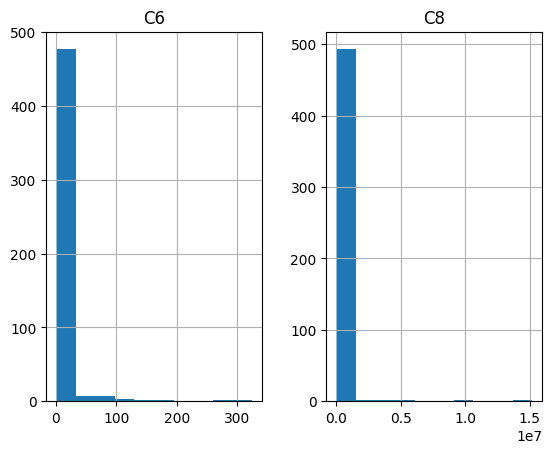

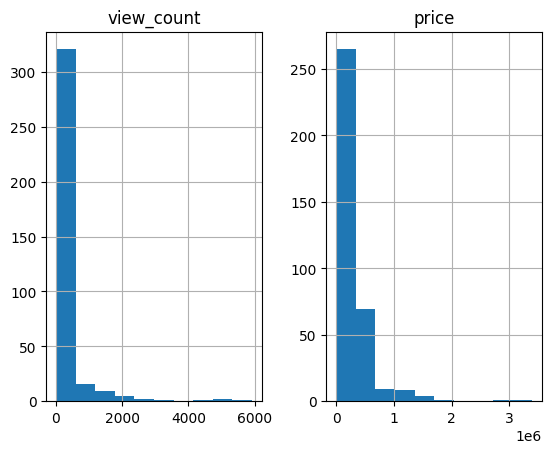

In [16]:
df1_copy1 = df1_copy1.apply(pd.to_numeric, errors='coerce')
df1_copy1.hist()
df0_copy0.hist()

In [17]:
# 필드 추출 함수 정의
def extract_fields(description):
    prompt = f""" 
우리는 여러 플랫폼에서 크롤링한 데이터를 통해 호텔과 숙박에 관한 노쇼 상품들을 판매할거야. 
기본 필드에서 가져올 수 있는 정보들을 제외하고 우리가 필요한 필드가 9개가 있어. 
이 9개의 필드는 
1. 노쇼 상품의 사용 날짜 및 기한을 나타내는 expiration_date
   이때 날짜가 범위로 표현되어 있다면 범위를 나타내고, 날짜가 없다면 null로 표기해줘.
2. 객실 타입을 나타내는 room_type
   문자열 형태이며 관련된 내용이 없다면 null로 입력해줘.
3. 사용 인원 수를 나타내는 head_count
   숫자 형식이며 성인이나 자녀에 대한 구분 없이 총 인원수만 입력해줘. 인원수에 대한 내용이 없다면 null로 기입해줘.
4. 배송비인 shipping_fee 
   배송비가 적혀있지 않다면 0으로 표기해줘 (숫자 형식).
5. 직거래인지 택배거래인지 알 수 있는 거래 유형인 transaction_method
   직거래라는 단어가 있으면 '직거래'로, 택배거래라는 단어가 있으면 '택배거래'로 표기해줘.
   두 단어가 모두 없으면 null로 표기해줘.
6. 원래 노쇼 상품의 가격인 시중 가격인 market_price 
   시중 가격이 나와 있지 않다면 null로 표기해줘 (숫자 형식).
   만약 23.3만원 이런식으로 적혀져 있다면 market_price는 233000으로 입력되어야해.
7. 조식 여부나 사우나 여부, 수영장 여부 등의 호텔에서 사용할 수 있는 서비스 이용 여부를 알 수 있는 옵션인 options
   서비스 관련 내용이 없다면 null로 표기해줘.
8. 주차 여부를 나타내는 parking
   주차 여부가 있으면 TRUE로, 없으면 FALSE로 표기해줘. 주차 여부 정보가 없다면 null로 표기해줘.
9. 호텔 체크인/체크 아웃 시간을 나타내는 check_in_out_time
   체크인 시간과 체크아웃 시간을 시간 형태로 작성해줘. 기본 형태는 체크인 시간 / 체크아웃 시간이야. 
   만약 체크인 시간이 없으면 null / 체크아웃 시간으로 기입해주고, 만약 체크아웃 시간이 없으면 체크인 시간 / null으로 기입해주고, 둘 다 없으면 아예 null로 작성해줘.

그래서 상세 설명을 주면 거기서 9개의 필드에 해당하는 정보만 json형태로 추출해줘.:

설명: {description}

필드:
- expiration_date:
- room_type:
- head_count:
- shipping_fee:
- transaction_method:
- market_price:
- options:
- parking:
- check_in_out_time:
"""
    
    # OpenAI API 호출
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a helpful assistant."},
                  {"role": "user", "content": prompt}],
        max_tokens=1000
    )
    
    # 결과 추출
    result = response['choices'][0]['message']['content'].strip()

    return result
    
df0_sample = df0.sample(n=5)
df0_sample
# 데이터 프레임의 각 행에 대해 필드 추출 적용
df0_sample['field'] = df0_sample['description'].apply(extract_fields)

# 결과 확인
print(df0_sample[['description', 'field']])

df1_sample = df1.head()
df1_sample
# 데이터 프레임의 각 행에 대해 필드 추출 적용
df1_sample['field'] = df1_sample['C10'].apply(extract_fields)

# 결과 확인
print(df1_sample[['C10', 'field']])  

                                           description  \
181                                                NaN   
70   10월5일 주말 숙박권\nexecutive twin 더블,싱글침대 2개\n소인포함 ...   
114  서울드래곤시티내 모든 레스토랑에서 이용가능\n레스토랑 2인 전용 50%할인 이용권(...   
250  이번에 새로 생긴 몬드리안 호텔입니다\n위치도 좋아서 여행하기에 딱이에요\n여행 못...   
269  9/14-9/15 토.일요일\n\n캐리비안베이 가려고 예약해었는데 못가게 되어 양도...   

                                                 field  
181  입력하신 설명에 따라 필요한 9개의 필드에 해당하는 정보만 추출하여 JSON 형식으...  
70   입력하신 설명을 기반으로 9개의 필드에 해당하는 정보를 추출하여 JSON 형태로 정...  
114  {\n  "expiration_date": "2022/12/24 - 2022/12/...  
250  문의 주셔서 감사합니다! 아래는 제공해주신 상세 설명에서 9개의 필드에 해당하는 정...  
269  {\n  "expiration_date": "9/14-9/15",\n  "room_...  
                                                 C10  \
0                                        description   
1  executive twin 더블,싱글침대 2개\n소인포함 최대4인까지 가능합니다.\...   
2  국내숙박 2만원 할인해서 대신예약 드려요.​\n\n​❗지역 : 비수도권 전지역 가능...   
3  리조트&호텔 여행사 "두번째 여행" 입니다\n\n(대명)소노호텔&리조트/ 켄싱턴 리...   
4  안녕 하세요. 남이섬 자라섬5분전\n 길목에 가

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26792\4226219577.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_sample['field'] = df1_sample['C10'].apply(extract_fields)


In [4]:
df_sample=pd.read_excel('C:/Users/Administrator/Desktop/내배캠/vscode/temp/데이터/오픈마켓 노쇼핑 샘플 데이터.xlsx')
df_sample.head(5)

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,seller_location,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,당근마켓,https://www.daangn.com/articles/836464147,2024-10-02 12:54:31.443000,호텔 양도,664,11,"11,111원",https://img.kr.gcp-karroter.net/origin/article...,"1. 횡성 웰리힐리파크리조트 \n- 10월 3일, 4일, 5일 패밀리룸 (15만원)...",티켓/교환권,...,연수구 송도3동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,당근마켓,https://www.daangn.com/articles/832373103,2024-10-02 12:53:31.443000,속초 체스터톤스 호텔,310,7,"170,000원",https://img.kr.gcp-karroter.net/origin/article...,속초 체스터톤스 숙박권입니다.\n3매구요~\n원하는 매수 만큼 가능하세요.\n투룸 ...,티켓/교환권,...,부천시 여월동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,당근마켓,https://www.daangn.com/articles/840996796,2024-10-02 12:52:31.443000,수성호텔 vip 티켓 1장,4,0,"34,000원",https://img.kr.gcp-karroter.net/origin/article...,"수성호텔 호텔수성 vip 티켓 (수영장,루프탑,인피니티풀, 온천, 사우나, 이벤트...",티켓/교환권,...,북구 매천동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,당근마켓,https://www.daangn.com/articles/840996718,2024-10-02 12:52:31.443000,코엑스 주차권 (유효기간없음),11,1,"5,000원",https://img.kr.gcp-karroter.net/origin/article...,코엑스 5시간 주차권입니다.\n(원래 코엑스 기본 주차요금 1시간 6000원) \n...,티켓/교환권,...,강남구 개포동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_sample0=df_sample.copy()
df_sample0.head(5)

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,seller_location,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,당근마켓,https://www.daangn.com/articles/836464147,2024-10-02 12:54:31.443000,호텔 양도,664,11,"11,111원",https://img.kr.gcp-karroter.net/origin/article...,"1. 횡성 웰리힐리파크리조트 \n- 10월 3일, 4일, 5일 패밀리룸 (15만원)...",티켓/교환권,...,연수구 송도3동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,당근마켓,https://www.daangn.com/articles/832373103,2024-10-02 12:53:31.443000,속초 체스터톤스 호텔,310,7,"170,000원",https://img.kr.gcp-karroter.net/origin/article...,속초 체스터톤스 숙박권입니다.\n3매구요~\n원하는 매수 만큼 가능하세요.\n투룸 ...,티켓/교환권,...,부천시 여월동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,당근마켓,https://www.daangn.com/articles/840996796,2024-10-02 12:52:31.443000,수성호텔 vip 티켓 1장,4,0,"34,000원",https://img.kr.gcp-karroter.net/origin/article...,"수성호텔 호텔수성 vip 티켓 (수영장,루프탑,인피니티풀, 온천, 사우나, 이벤트...",티켓/교환권,...,북구 매천동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,당근마켓,https://www.daangn.com/articles/840996718,2024-10-02 12:52:31.443000,코엑스 주차권 (유효기간없음),11,1,"5,000원",https://img.kr.gcp-karroter.net/origin/article...,코엑스 5시간 주차권입니다.\n(원래 코엑스 기본 주차요금 1시간 6000원) \n...,티켓/교환권,...,강남구 개포동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_sample0.describe()

,view_count,like_count,price,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
count,779.000000,779.000000,7.790000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,95.495507,1.838254,1.677104e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,317.090620,6.185398,3.600206e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,0.000000,6.767000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.000000,0.000000,8.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,47.500000,1.000000,3.000000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4413.000000,77.000000,1.000000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 결측값 확인
df_sample0['price'].isnull().sum()
# 결측값 있는 행 확인
df_sample0[df_sample0['price'].isnull()]
# 결측값인 행 2개 제거
df_sample0.drop([0,101],axis=0,inplace=True)

In [8]:
df_sample0['price'] = df_sample0['price'].astype(str)
# 문자열 대체 후 int 타입으로 변경
df_sample0['price'] = df_sample0['price'].str.replace(',','').str.replace('만원','0000').str.replace('만','').str.replace('원','').str.replace(' ','').astype(int)


In [15]:
df_sample0['view_count'] = df_sample0['view_count'].astype(str)
df_sample0['like_count'] = df_sample0['like_count'].astype(str)
df_sample0['view_count'] = df_sample0['view_count'].str.replace('조회','')
df_sample0['like_count'] = df_sample0['like_count'].str.replace('시세조회','')
df_sample0['view_count'] = df_sample0['view_count'].astype(int)
df_sample0['like_count'] = df_sample0['like_count'].astype(int)

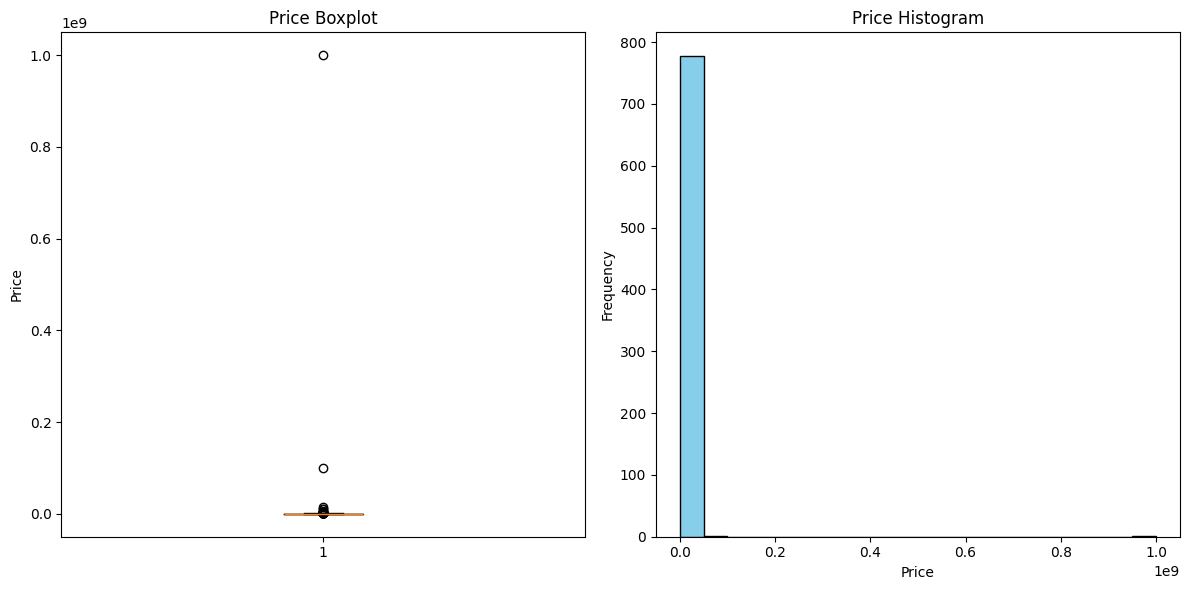

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].boxplot(df_sample0['price'])
axes[0].set_title('Price Boxplot')
axes[0].set_ylabel('Price')

axes[1].hist(df_sample0['price'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Price Histogram')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

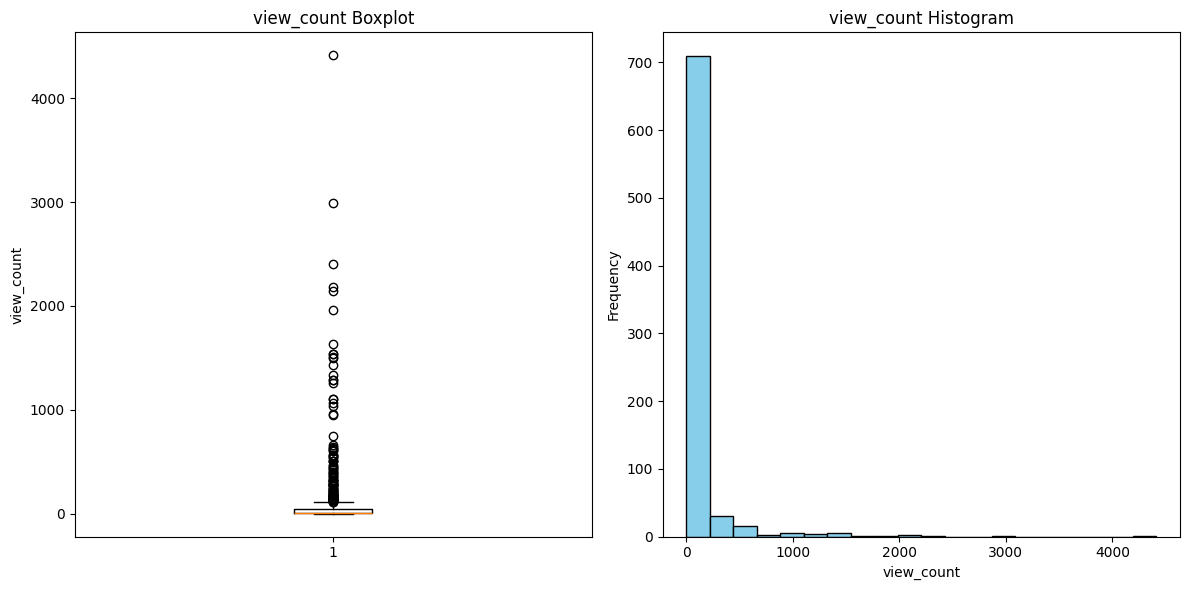

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(df_sample0['view_count'])
axes[0].set_title('view_count Boxplot')
axes[0].set_ylabel('view_count')

axes[1].hist(df_sample0['view_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('view_count Histogram')
axes[1].set_xlabel('view_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

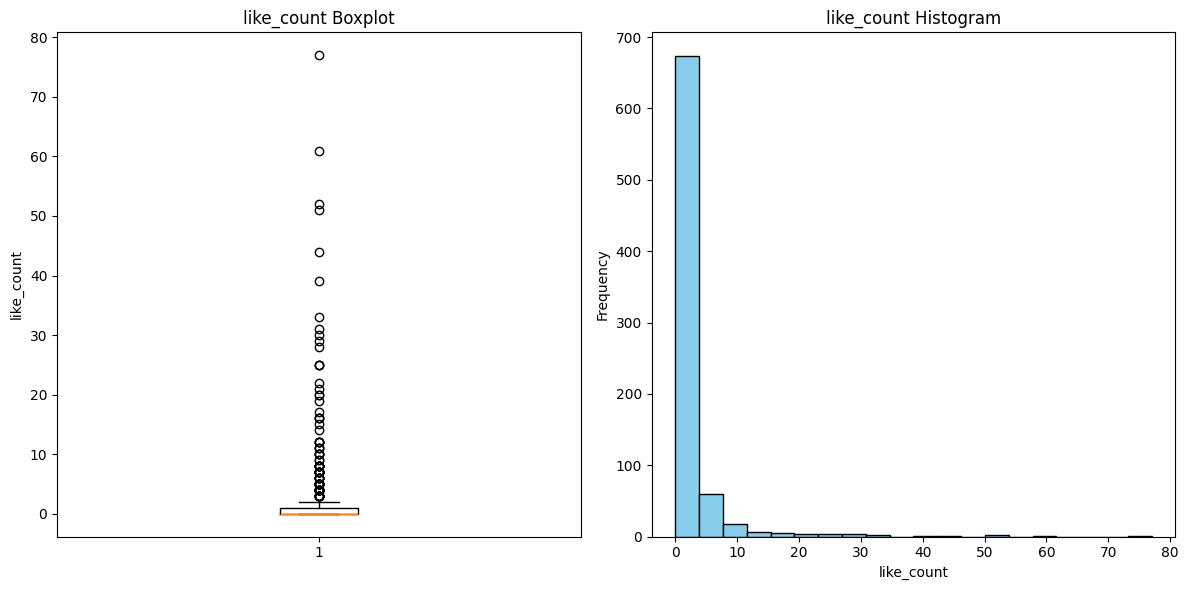

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(df_sample0['like_count'])
axes[0].set_title('like_count Boxplot')
axes[0].set_ylabel('like_count')

axes[1].hist(df_sample0['like_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('like_count Histogram')
axes[1].set_xlabel('like_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
df_sample0['category'].unique()

array(['티켓/교환권', '스포츠/레저', '기타 중고물품', '생활/주방', '가구/인테리어', '가공식품', '도서',
       '취미/게임/음반', '여성의류', '뷰티/미용', '여행/숙박/렌트', '만화', '테마파크', '콘서트',
       '학습도구/문구/필기류', '기타(티켓)', '외식', '시/소설', '학습/사전/참고서', '여행/취미/레저/건강',
       '기타(상품권)', '경제/경영', '예술/디자인', '공연/전시/행사', nan], dtype=object)